# Spike rates

author: steeve.laquitaine@epfl.ch  
date: 29.08.2023   
modified: 22.09.2023   
display status: up-to-date  
regression: None

### Datasets 

Real datasets:

in-silico: 

* hybrid_janelia
    * in total there 60 recordings with two separate unit populations, different channel counts, durations
    * we combined firing rate from recordings 0 and 4, each have a separate units to max number of units
* synth_monotrode: 
    * 111 recordings, fixed channel count, different units and unit counts
    * 95 simulations of 10 min
    * number of units changes between simulations
    * Pedreira et al., “How Many Neurons Can We See with Current Spike Sorting Algorithms?”
* buccino 2020
    * 10 min neuropixel recording MEAREC hybrid with 250 units (200 excit. 50 inhib.) from BBP's NMC
* npx32
* npx384
* npx384-hex0

Note: 
    * MEAREC: https://zenodo.org/record/3696926


NOTE:

## Setup

Activate `firing_rate` environment (select interpreter - find envs/ path - add kernel)

```bash
# One-time initialization and follow instructions
kachery-cloud-init
```

In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import spikeforest as sf
import os 
import pandas as pd
import spikeinterface as si
import warnings
import logging
import matplotlib

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/bernstein_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
from src.nodes.study import spikestats
from src.nodes.postpro.npx_cell_types import get_interneurons
from src.nodes.postpro.allen_cell_types import load_session_data, load_all_sorted_spont_firing_rates, get_optotagged_neurons, get_spont_firing_rates

# IN-VIVO
# -------

# Horvath
EXPERIMENT = "vivo_horvath"   
SIMULATION_DATE = "2021_file_1"
data_conf_horvath_1, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
RECORDING_PATH_HORVATH_1 = data_conf_horvath_1["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_HORVATH_1 = data_conf_horvath_1["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_HORVATH_1 = data_conf_horvath_1["features"]["sorted_ks3"]["firing_rates"]

SIMULATION_DATE = "2021_file_2"
data_conf_horvath_2, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
RECORDING_PATH_HORVATH_2 = data_conf_horvath_2["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_HORVATH_2 = data_conf_horvath_2["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_HORVATH_2 = data_conf_horvath_2["features"]["sorted_ks3"]["firing_rates"]

SIMULATION_DATE = "2021_file_3"
data_conf_horvath_3, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
RECORDING_PATH_HORVATH_3 = data_conf_horvath_3["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_HORVATH_3 = data_conf_horvath_3["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_HORVATH_3 = data_conf_horvath_3["features"]["sorted_ks3"]["firing_rates"]


# Buzsaki
EXPERIMENT = "supp/buzsaki"       # specifies the experiment 
SIMULATION_DATE = "2015"      # specifies the run (date)
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
FIG_buzsaki = data_conf["fig_3b"]["data_mean_all"]

# Allen
EXPERIMENT = "supp/allen_neuropixels"  # the experiment 
SIMULATION_DATE = "2023_08_30"    # the run (date)
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()
RAW_DATA = data_conf["raw_data"]["input"]
PARV_SESSION_ID = 829720705 # parvalbumin tagged data
SST_SESSION_ID = 839068429  # somatostatin tagged data
VIP_SESSION_ID = 835479236  # vip tagged data
manifest_path = os.path.join(RAW_DATA, "manifest.json")


# IN-SILICO
# ---------

# HYBRID JANELIA (recordings 0 and 4, spikeforest)
EXPERIMENT = "supp/hybrid_janelia"       # specifies the experiment 
SIMULATION_DATE = "2023_06_10"      # specifies the run (date)
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
JANELIA_FR_FILE_PATH = data_conf["sorting"]["ground_truth"]["firing_rates"]

# SYNTH MONOTRODE
EXPERIMENT = "synth_monotrode"       # specifies the experiment 
SIMULATION_DATE = "2023_06_10"      # specifies the run (date)
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
SYNTH_MONOTRODE_FR_FILE_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["firing_rates"]

# BUCCINO 2020
EXPERIMENT = "buccino_2020"
SIMULATION_DATE = "2020"
data_conf_bucci, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()
# BUCCI_RECORDING_PATH = data_conf["recording"]["input"]
BUCCI_RECORDING_PATH = data_conf_bucci["preprocessing"]["output"]["trace_file_path"]
BUCCI_GT_SORTING_PATH = data_conf_bucci["sorting"]["simulation"]["ground_truth"]["output"]
BUCCI_FR_FILE_PATH = data_conf_bucci["features"]["ground_truth"]["firing_rates"]
BUCCI_SORTED_PATH = data_conf_bucci["sorting"]["sorters"]["kilosort3"]["output"]
BUCCI_SORTED_FR_FILE_PATH = data_conf_bucci["features"]["sorted_ks3"]["firing_rates"]

# npx32
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
data_conf32, param_conf32 = get_config(EXPERIMENT, SIMULATION_DATE).values()
npx32_RECORDING_PATH = data_conf32["preprocessing"]["output"]["trace_file_path"]
npx32_GT_SORTING_PATH = data_conf32["sorting"]["simulation"]["ground_truth"]["output"]
npx32_FR_FILE_PATH = data_conf32["sorting"]["simulation"]["ground_truth"]["firing_rates"]
npx32_SORTED_PATH = data_conf32["sorting"]["sorters"]["kilosort3"]["output"]
npx32_SORTED_FR_FILE_PATH = data_conf32["features"]["sorted_ks3"]["firing_rates"]


# npx384 - hex01
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_08_17"
data_conf384, param_conf384 = get_config(EXPERIMENT, SIMULATION_DATE).values()
npx384_RECORDING_PATH = data_conf384["preprocessing"]["output"]["trace_file_path"]
npx384_GT_SORTING_PATH = data_conf384["sorting"]["simulation"]["ground_truth"]["output"]
npx384_FR_FILE_PATH = data_conf384["sorting"]["simulation"]["ground_truth"]["firing_rates"]
npx384_SORTED_PATH = data_conf384["sorting"]["sorters"]["kilosort3"]["output"]
npx384_SORTED_FR_FILE_PATH = data_conf384["features"]["sorted_ks3"]["firing_rates"]
npx384_MATCH_FILE = data_conf384["sorting"]["sorters"]["kilosort3"]["match_with_cell_type"]

# npx384 - hex0
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_09_12"
data_conf384_hex0, param_conf384_hex0 = get_config(EXPERIMENT, SIMULATION_DATE).values()
npx384_hex0_RECORDING_PATH = data_conf384_hex0["preprocessing"]["output"]["trace_file_path"]
npx384_hex0_GT_SORTING_PATH = data_conf384_hex0["sorting"]["simulation"]["ground_truth"]["output"]
npx384_hex0_FR_FILE_PATH = data_conf384_hex0["sorting"]["simulation"]["ground_truth"]["firing_rates"]
npx384_hex0_SORTED_PATH = data_conf384_hex0["sorting"]["sorters"]["kilosort3"]["output"]
npx384_hex0_SORTED_FR_FILE_PATH = data_conf384_hex0["features"]["sorted_ks3"]["firing_rates"]
npx384_hex0_MATCH_FILE = data_conf384_hex0["sorting"]["sorters"]["kilosort3"]["match_with_cell_type"]

# npx384-hex0-pfr09
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_09_19"
data_conf384_hex0_pfr09, param_conf384_hex0_pfr09 = get_config(EXPERIMENT, SIMULATION_DATE).values()
npx384_hex0_pfr09_RECORDING_PATH = data_conf384_hex0_pfr09["preprocessing"]["output"]["trace_file_path"]
npx384_hex0_pfr09_GT_SORTING_PATH = data_conf384_hex0_pfr09["sorting"]["simulation"]["ground_truth"]["output"]
npx384_hex0_pfr09_FR_FILE_PATH = data_conf384_hex0_pfr09["sorting"]["simulation"]["ground_truth"]["firing_rates"]
npx384_hex0_pfr09_SORTED_PATH = data_conf384_hex0_pfr09["sorting"]["sorters"]["kilosort3"]["output"]
npx384_hex0_pfr09_SORTED_FR_FILE_PATH = data_conf384_hex0_pfr09["features"]["sorted_ks3"]["firing_rates"]
npx384_hex0_pfr09_MATCH_FILE = data_conf384_hex0_pfr09["sorting"]["sorters"]["kilosort3"]["match_with_cell_type"]

# silence info and warnings
warnings.filterwarnings('ignore')
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

2023-09-26 11:17:20,696 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-26 11:17:20,719 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-26 11:17:20,720 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-26 11:17:20,728 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-26 11:17:20,730 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-26 11:17:20,738 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-26 11:17:20,740 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-26 11:17:20,742 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-26 11:17:20,744 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-26 11:17:20,749 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-26 11:17:20,751 - root - utils.py - get_config 

### Ground truth: vivo vs. silico

Zador (cited in Buzsaki) plots a probability density function (not probabilities). So the probabilities do not need to sum to 1. The probabilities weighted by dx should follow $\int_{x_0}^{x_1} f(x)dx \le 1$.
We converted the continuous pdf to a discrete probability mass function that sums to 1 for comparison with our distributions.


In [2]:
# janelia (recordings 0 and 4)
firing_rates_janelia = spikestats.compute_spike_rate_janelia(
    JANELIA_FR_FILE_PATH, save=True
)
# monotrode
firing_rates_monotrode = spikestats.compute_spike_rate_monotrode(
    SYNTH_MONOTRODE_FR_FILE_PATH, save=True
)
# Buccino 2020
firing_rates_buccino2020 = spikestats.compute_spike_rate_buccino2020(
    BUCCI_RECORDING_PATH, BUCCI_GT_SORTING_PATH, BUCCI_FR_FILE_PATH, save=True
)
# npx32-hex0
firing_rates_npx32, pyramidal_rate32, interneuron_rate32 = (
    spikestats.compute_spike_rate_npx32(
        data_conf32,
        npx32_RECORDING_PATH,
        npx32_GT_SORTING_PATH,
        npx32_FR_FILE_PATH,
        save=True,
    )
)
# npx384-hex01
firing_rates_npx384, unit_ids_npx384 = spikestats.compute_spike_rate_npx384(
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_GT_SORTING_PATH,
    npx384_FR_FILE_PATH,
    save=True,
)
# npx384-hex0
firing_rates_npx384_hex0, unit_ids_npx384_hex0 = spikestats.compute_spike_rate_npx384(
    data_conf384_hex0,
    npx384_hex0_RECORDING_PATH,
    npx384_hex0_GT_SORTING_PATH,
    npx384_hex0_FR_FILE_PATH,
    save=True,
)
# npx384-hex0-pfr09
firing_rates_npx384_hex0_pfr09, unit_ids_npx384_hex0_pfr09 = (
    spikestats.compute_spike_rate_npx384(
        data_conf384_hex0_pfr09,
        npx384_hex0_pfr09_RECORDING_PATH,
        npx384_hex0_pfr09_GT_SORTING_PATH,
        npx384_hex0_pfr09_FR_FILE_PATH,
        save=True,
    )
)

unit count: 74
unit count: 74

Monotrode

Buccino_2020

npx32

npx384

npx384

npx384


All model firing rates are non null.

In [3]:
# sanity-check
# - no firing rate should be 0 for fair comparison with in-vivo (whole-cell patch clamp neuron detection requires at least 1 spike)
assert all(firing_rates_npx384 != 0), "All firing rates should be > 0"
assert all(firing_rates_npx384_hex0 != 0), "All firing rates should be > 0"
assert all(firing_rates_npx384_hex0_pfr09 != 0), "All firing rates should be > 0"
assert all(firing_rates_npx32 != 0), "All firing rates should be > 0"
assert all(firing_rates_monotrode != 0), "All firing rates should be > 0"
assert all(firing_rates_janelia != 0), "All firing rates should be > 0"
assert all(firing_rates_buccino2020 != 0), "All firing rates should be > 0"

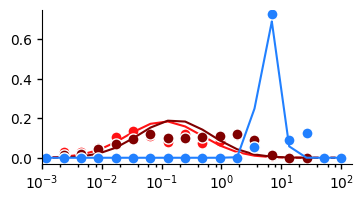

In [48]:
# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1 ^ 100  # seconds until experimenter decides a cell is silent

ax = plt.figure(figsize=(4, 2)).gca()

MARKERSIZE = 8

# npx32
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_npx32,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"npx32 (1 col, n={len(firing_rates_npx32)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)
# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"npx384 (7 cols, n={len(firing_rates_npx384)})",
    color=(0.5, 0, 0),
    markerfacecolor=(0.5, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)
# Buccino 2020
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_buccino2020,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"Buccino (ref 6, n={len(firing_rates_buccino2020)})",
    color=(0.13, 0.50, 1),
    markerfacecolor=(0.13, 0.50, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)
# Janelia
# spikestats.plot_firing_rate_hist_ground_truths(firing_rates_janelia, log_x_min, log_x_max, nbins, t_dec, ax, label=f"hybrid Janelia (ref 7, n={len(firing_rates_janelia)})", color=(0.75, 0.8, 0.34), markerfacecolor=(0.38, 0.70, 0), markeredgecolor="w", linestyle="-",markersize=5.5, legend=False)
# monotrode
# spikestats.plot_firing_rate_hist_ground_truths(firing_rates_monotrode, log_x_min, log_x_max, nbins, t_dec, ax, label=f"synth monotrode (ref 5, n={len(firing_rates_monotrode)})",color = (1, 0.50, 0.2) , markerfacecolor=(1, 0.50, 0.2), markeredgecolor="w", linestyle="-",markersize=5.5, legend=False)

# show minor ticks
ax.tick_params(which="both", width=1)
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.ylim([-0.03, 0.75])

# save figures
plt.savefig("figures/2_realism/4_firing_rate/pdf/all_gt.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/all_gt.svg")

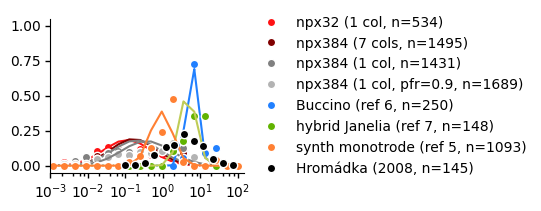

In [47]:
# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1 ^ 100  # seconds until experimenter decides a cell is silent

ax = plt.figure(figsize=(2.5, 2)).gca()

MARKERSIZE = 6

# npx32
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_npx32,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"npx32 (1 col, n={len(firing_rates_npx32)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"npx384 (7 cols, n={len(firing_rates_npx384)})",
    color=(0.5, 0, 0),
    markerfacecolor=(0.5, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)

# npx384-hex0
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_npx384_hex0,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"npx384 (1 col, n={len(firing_rates_npx384_hex0)})",
    color=(0.5, 0.5, 0.5),
    markerfacecolor=(0.5, 0.5, 0.5),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)

# npx384-hex0-pfr09
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_npx384_hex0_pfr09,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"npx384 (1 col, pfr=0.9, n={len(firing_rates_npx384_hex0_pfr09)})",
    color=(0.5, 0.5, 0.5),
    markerfacecolor=(0.7, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)

# Buccino 2020
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_buccino2020,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"Buccino (ref 6, n={len(firing_rates_buccino2020)})",
    color=(0.13, 0.50, 1),
    markerfacecolor=(0.13, 0.50, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)

# Janelia
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_janelia,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"hybrid Janelia (ref 7, n={len(firing_rates_janelia)})",
    color=(0.75, 0.8, 0.34),
    markerfacecolor=(0.38, 0.70, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)

# monotrode
spikestats.plot_firing_rate_hist_ground_truths(
    firing_rates_monotrode,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"synth monotrode (ref 5, n={len(firing_rates_monotrode)})",
    color=(1, 0.50, 0.2),
    markerfacecolor=(1, 0.50, 0.2),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)

# get plot-extracted (WebPlotDigitizer) data Buzsaki
data_mean_all = pd.read_csv(FIG_buzsaki)
ax.plot(
    data_mean_all.x,
    data_mean_all.y / sum(data_mean_all.y),
    "k",
    marker="o",
    linestyle="None",
    label="Hromádka (2008, n=145)",
    markersize=6,
    markeredgecolor="w",
)
ax.set_xscale("log")
plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

# show minor ticks
ax.tick_params(which="both", width=1)
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save figures
# plt.savefig("figures/2_realism/4_firing_rate/pdf/all_gt.pdf")
# plt.savefig("figures/2_realism/4_firing_rate/svg/all_gt.svg")

### Sorted

#### vivo vs. silico

Because sorting accuracy depends on probe geometry, we discarded `Hybrid Janelia` for this analysis.  

`Hybrid Janelia` was simulated for tetrodes not for neuropixels, so comparing the sorted distributions with our simulations and in-vivo datasets with neuropixels would not be very meaningful.

Compute

In [5]:
# IN-VIVO

# horvath
sorted_horvath_1 = spikestats.compute_sorted_spike_rate_npx(
    data_conf_horvath_1,
    RECORDING_PATH_HORVATH_1,
    SORTED_PATH_HORVATH_1,
    SORTED_FR_FILE_PATH_HORVATH_1,
    save=True,
)
sorted_horvath_2 = spikestats.compute_sorted_spike_rate_npx(
    data_conf_horvath_2,
    RECORDING_PATH_HORVATH_2,
    SORTED_PATH_HORVATH_2,
    SORTED_FR_FILE_PATH_HORVATH_2,
    save=True,
)
sorted_horvath_3 = spikestats.compute_sorted_spike_rate_npx(
    data_conf_horvath_3,
    RECORDING_PATH_HORVATH_3,
    SORTED_PATH_HORVATH_3,
    SORTED_FR_FILE_PATH_HORVATH_3,
    save=True,
)
sorted_horvath = np.hstack([sorted_horvath_1, sorted_horvath_2, sorted_horvath_3])

# allen
session_parv = load_session_data(PARV_SESSION_ID, manifest_path)
sorted_allen = np.array(load_all_sorted_spont_firing_rates(session_parv, "VIS"))

# IN-SILICO

# npx384
sorted_384 = spikestats.compute_sorted_spike_rate_npx(
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    npx384_SORTED_FR_FILE_PATH,
    save=True,
)
# npx384-hex0
sorted_384_hex0 = spikestats.compute_sorted_spike_rate_npx(
    data_conf384_hex0,
    npx384_hex0_RECORDING_PATH,
    npx384_hex0_SORTED_PATH,
    npx384_hex0_SORTED_FR_FILE_PATH,
    save=True,
)
# npx384-hex0-pfr09
sorted_384_hex0_pfr09 = spikestats.compute_sorted_spike_rate_npx(
    data_conf384_hex0_pfr09,
    npx384_hex0_pfr09_RECORDING_PATH,
    npx384_hex0_pfr09_SORTED_PATH,
    npx384_hex0_pfr09_SORTED_FR_FILE_PATH,
    save=True,
)
# npx32
sorted_32 = spikestats.compute_sorted_spike_rate_npx(
    data_conf32,
    npx32_RECORDING_PATH,
    npx32_SORTED_PATH,
    npx32_SORTED_FR_FILE_PATH,
    save=True,
)
# Buccino
sorted_bucci = spikestats.compute_sorted_spike_rate_buccino2020(
    BUCCI_RECORDING_PATH, BUCCI_SORTED_PATH, BUCCI_SORTED_FR_FILE_PATH, save=True
)


Buccino_2020


In [6]:
# sanity-check
# - having sorted firing rates equal 0 would be meaningless
assert all(sorted_horvath != 0), "All firing rates should be > 0"
assert all(sorted_allen != 0), "All firing rates should be > 0"
assert all(sorted_384 != 0), "All firing rates should be > 0"
assert all(sorted_384_hex0 != 0), "All firing rates should be > 0"
assert all(sorted_384_hex0_pfr09 != 0), "All firing rates should be > 0"
assert all(sorted_32 != 0), "All firing rates should be > 0"
assert all(sorted_bucci != 0), "All firing rates should be > 0"

Plot

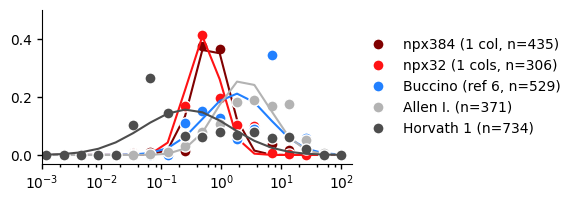

In [39]:
# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

fig, axes = plt.subplots(1, 1, figsize=(4, 2))

MARKERSIZE = 8

# npx384-hex0
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_384_hex0,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"npx384 (1 col, n={len(sorted_384_hex0)})",
    color=(0.5, 0, 0),
    markerfacecolor=(0.5, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)
# npx384-hex0-pfr09
# spikestats.plot_firing_rate_hist_ground_truths(sorted_384_hex0_pfr09, log_x_min, log_x_max, nbins, t_dec, axes, label=f"npx384 (1 col, prf=0.9, n={len(sorted_384_hex0_pfr09)})", color=(.5,0,0), markerfacecolor=(.5,0,0), markeredgecolor="w", linestyle="-",markersize=5.5, legend=False);
# npx32
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_32,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"npx32 (1 cols, n={len(sorted_32)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)
# Buccino
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_bucci,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"Buccino (ref 6, n={len(sorted_bucci)})",
    color=(0.13, 0.50, 1),
    markerfacecolor=(0.13, 0.50, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
)
# Allen Inst. mice
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_allen,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"Allen I. (n={len(sorted_allen)})",
    color=(0.7, 0.7, 0.7),
    markerfacecolor=(0.7, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# horvath
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_horvath,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"Horvath 1 (n={len(sorted_horvath)})",
    color=(0.3, 0.3, 0.3),
    markerfacecolor=(0.3, 0.3, 0.3),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)

plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylim([-0.03, 0.5])

# save figures
plt.savefig("figures/2_realism/4_firing_rate/pdf/all_sorted.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/all_sorted.svg")

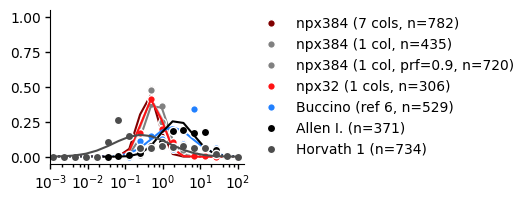

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(2.5, 2))

# npx384-hex01
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"npx384 (7 cols, n={len(sorted_384)})",
    color=(0.5, 0, 0),
    markerfacecolor=(0.5, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)
# npx384-hex0
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_384_hex0,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"npx384 (1 col, n={len(sorted_384_hex0)})",
    color=(0.5, 0.5, 0.5),
    markerfacecolor=(0.5, 0.5, 0.5),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)
# npx384-hex0-pfr09
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_384_hex0_pfr09,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"npx384 (1 col, prf=0.9, n={len(sorted_384_hex0_pfr09)})",
    color=(0.7, 0.7, 0.7),
    markerfacecolor=(0.5, 0.5, 0.5),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)
# npx32
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_32,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"npx32 (1 cols, n={len(sorted_32)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)
# Buccino
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_bucci,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"Buccino (ref 6, n={len(sorted_bucci)})",
    color=(0.13, 0.50, 1),
    markerfacecolor=(0.13, 0.50, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)
# Allen Inst. mice
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_allen,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"Allen I. (n={len(sorted_allen)})",
    color=(0, 0, 0),
    markerfacecolor=(0, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=6,
    legend=False,
    lognormal=True,
)
# horvath
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_horvath,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"Horvath 1 (n={len(sorted_horvath)})",
    color=(0.3, 0.3, 0.3),
    markerfacecolor=(0.3, 0.3, 0.3),
    markeredgecolor="w",
    linestyle="-",
    markersize=6,
    legend=False,
    lognormal=True,
)

plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

# save figures
# plt.savefig("figures/2_realism/4_firing_rate/pdf/all_sorted.pdf")
# plt.savefig("figures/2_realism/4_firing_rate/svg/all_sorted.svg")

#### By cell type

Compute

In [7]:
# takes 4 min

# Allen neuropixels

# from a Parv mice
session_parv = load_session_data(PARV_SESSION_ID, manifest_path)
all_firing_rates_parv_mice = load_all_sorted_spont_firing_rates(session_parv, "VIS")

# from a SST mice
session_sst = load_session_data(SST_SESSION_ID, manifest_path)
all_firing_rates_sst_mice = load_all_sorted_spont_firing_rates(session_sst, "VIS")

# from a vip mice
session_vip = load_session_data(VIP_SESSION_ID, manifest_path)
all_firing_rates_vip_mice = load_all_sorted_spont_firing_rates(session_vip, "VIS")

# get firing rates of all neurons except FFI
parv_neurons = get_optotagged_neurons(session_parv)
parv_non_FFI = set(all_firing_rates_parv_mice.index) - set(parv_neurons)
parv_ffi_removed_fr = get_spont_firing_rates(session_parv, parv_non_FFI)

# get firing rates of all neurons except SST
sst_neurons = get_optotagged_neurons(session_sst)
sst_non_FFI = set(all_firing_rates_sst_mice.index) - set(sst_neurons)
sst_ffi_removed_fr = get_spont_firing_rates(session_sst, sst_non_FFI)

# get firing rates of all neurons except VIP
vip_neurons = get_optotagged_neurons(session_vip)
vip_non_FFI = set(all_firing_rates_vip_mice.index) - set(vip_neurons)
vip_ffi_removed_fr = get_spont_firing_rates(session_vip, vip_non_FFI)

# get firing rates for cell type
parv_fr = get_spont_firing_rates(session_parv, parv_neurons)
sst_fr = get_spont_firing_rates(session_sst, sst_neurons)
vip_fr = get_spont_firing_rates(session_vip, vip_neurons)

# npx 384

# get neurons by cell types
matching = pd.read_csv(npx384_MATCH_FILE)

# drop duplicates sorted units
sorted_neurons_384 = matching[["sorted", "cell_type"]]
sorted_neurons_384 = sorted_neurons_384.drop_duplicates()

# get all except FFI
not_parv_neurons_384 = sorted_neurons_384[sorted_neurons_384["cell_type"] != "parv"][
    "sorted"
].values
parv_neurons_384 = sorted_neurons_384[sorted_neurons_384["cell_type"] == "parv"][
    "sorted"
].values

# get all except sst
not_sst_neurons_384 = sorted_neurons_384[sorted_neurons_384["cell_type"] != "sst"][
    "sorted"
].values
sst_neurons_384 = sorted_neurons_384[sorted_neurons_384["cell_type"] == "sst"][
    "sorted"
].values

# get all except vip
not_vip_neurons_384 = sorted_neurons_384[sorted_neurons_384["cell_type"] != "vip"][
    "sorted"
].values
vip_neurons_384 = sorted_neurons_384[sorted_neurons_384["cell_type"] == "vip"][
    "sorted"
].values

# get firing rates of all neurons except FFI
not_parv_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    not_parv_neurons_384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)
parv_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    parv_neurons_384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)

# get firing rates of all neurons except sst
not_sst_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    not_sst_neurons_384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)
sst_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    sst_neurons_384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)

# get firing rates of all neurons except vip
not_vip_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    not_vip_neurons_384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)
vip_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    vip_neurons_384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)


# drop units with 0 firing rates [TODO: check how possible. SHould not be possible to have 0 firing rate units!]
not_parv_fr_npx384 = not_parv_fr_npx384[not_parv_fr_npx384 != 0]
parv_fr_npx384 = parv_fr_npx384[parv_fr_npx384 != 0]
not_sst_fr_npx384 = not_sst_fr_npx384[not_sst_fr_npx384 != 0]
sst_fr_npx384 = sst_fr_npx384[sst_fr_npx384 != 0]
not_vip_fr_npx384 = not_vip_fr_npx384[not_vip_fr_npx384 != 0]
vip_fr_npx384 = vip_fr_npx384[vip_fr_npx384 != 0]

# unit-test
assert len(parv_ffi_removed_fr) == len(set(all_firing_rates_parv_mice.index)) - len(
    set(parv_neurons)
), "else something's wrong"
assert len(sst_ffi_removed_fr) == len(set(all_firing_rates_sst_mice.index)) - len(
    set(sst_neurons)
), "else something's wrong"
assert len(vip_ffi_removed_fr) == len(set(all_firing_rates_vip_mice.index)) - len(
    set(vip_neurons)
), "else something's wrong"

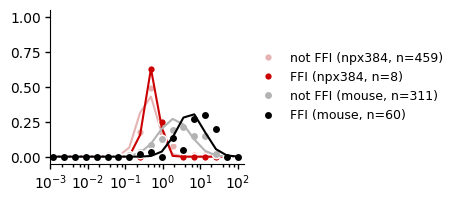

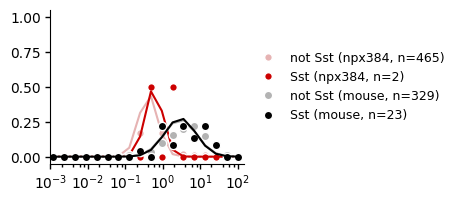

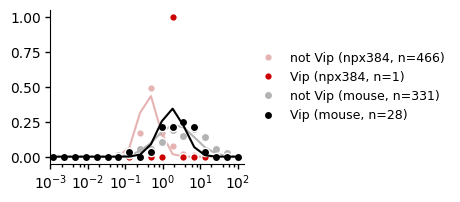

In [8]:
# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 30 # seconds until experimenter decides a cell is silent
t_dec = 1 ^ 100  # seconds until experimenter decides a cell is silent

# fig, axes = plt.subplots(1,3,figsize=(8,2))

ax = plt.figure(figsize=(2.5, 2)).gca()

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    not_parv_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not FFI (npx384, n={len(not_parv_fr_npx384)})",
    color=(0.9, 0.7, 0.7),
    markerfacecolor=(0.9, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    parv_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"FFI (npx384, n={len(parv_fr_npx384)})",
    color=(0.8, 0, 0),
    markerfacecolor=(0.8, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)

# mouse 1 (parv. tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(parv_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not FFI (mouse, n={len(parv_ffi_removed_fr)})",
    color=(0.7, 0.7, 0.7),
    markerfacecolor=(0.7, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=6,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(parv_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"FFI (mouse, n={len(parv_fr)})",
    color=(0, 0, 0),
    markerfacecolor=(0, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=6,
    legend=False,
)

# axes[0].set_ylabel("probability (ratio)", fontsize=9)
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

# save figures
plt.savefig("figures/2_realism/4_firing_rate/pdf/FFI_sorted.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/FFI_sorted.svg")


ax = plt.figure(figsize=(2.5, 2)).gca()

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    not_sst_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not Sst (npx384, n={len(not_sst_fr_npx384)})",
    color=(0.9, 0.7, 0.7),
    markerfacecolor=(0.9, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    sst_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"Sst (npx384, n={len(sst_fr_npx384)})",
    color=(0.8, 0, 0),
    markerfacecolor=(0.8, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)

# mouse 2 (Sst tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not Sst (mouse, n={len(sst_ffi_removed_fr)})",
    color=(0.7, 0.7, 0.7),
    markerfacecolor=(0.7, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=6,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"Sst (mouse, n={len(sst_fr)})",
    color=(0, 0, 0),
    markerfacecolor=(0, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=6,
    legend=False,
)

# axes[1].set_ylabel("probability (ratio)", fontsize=9)
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

plt.savefig("figures/2_realism/4_firing_rate/pdf/Sst_sorted.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/Sst_sorted.svg")

ax = plt.figure(figsize=(2.5, 2)).gca()

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    not_vip_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not Vip (npx384, n={len(not_vip_fr_npx384)})",
    color=(0.9, 0.7, 0.7),
    markerfacecolor=(0.9, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    vip_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"Vip (npx384, n={len(vip_fr_npx384)})",
    color=(0.8, 0, 0),
    markerfacecolor=(0.8, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=5.5,
    legend=False,
)

# mouse 3 (VIP tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not Vip (mouse, n={len(vip_ffi_removed_fr)})",
    color=(0.7, 0.7, 0.7),
    markerfacecolor=(0.7, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=6,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"Vip (mouse, n={len(vip_fr)})",
    color=(0, 0, 0),
    markerfacecolor=(0, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=6,
    legend=False,
)


# axes[2].set_ylabel("probability (ratio)", fontsize=9);
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
plt.savefig("figures/2_realism/4_firing_rate/pdf/Vip_sorted.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/Vip_sorted.svg")

### Ground truth: not-interneuron type vs. interneuron type

In [9]:
# GET INTERNEURONS
# ----------------
# takes 4 mins

# get FFI, sst, vip interneurons
parv_neurons_npx384 = get_interneurons(data_conf384, "LBC|NBC")
sst_neurons_npx384 = get_interneurons(data_conf384, "MC")
vip_neurons_npx384 = get_interneurons(data_conf384, "SBC")

# get all units except FFI, sst, vip
ffi_removed_units_npx384 = set(unit_ids_npx384) - set(parv_neurons_npx384)
sst_removed_units_npx384 = set(unit_ids_npx384) - set(sst_neurons_npx384)
vip_removed_units_npx384 = set(unit_ids_npx384) - set(vip_neurons_npx384)


# COMPUTE FIRING RATES
# --------------------
# takes 1 secs

# Compute firing rates

# parvalbumin (FFI)
parv_rates_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    parv_neurons_npx384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_GT_SORTING_PATH,
    [],
    save=False,
)
ffi_removed_rates_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    ffi_removed_units_npx384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_GT_SORTING_PATH,
    [],
    save=False,
)

# somatostatin
sst_rates_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    sst_neurons_npx384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_GT_SORTING_PATH,
    [],
    save=False,
)
sst_removed_rates_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    sst_removed_units_npx384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_GT_SORTING_PATH,
    [],
    save=False,
)

# vip
vip_rates_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    vip_neurons_npx384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_GT_SORTING_PATH,
    [],
    save=False,
)
vip_removed_rates_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    vip_removed_units_npx384,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_GT_SORTING_PATH,
    [],
    save=False,
)

#### Plot

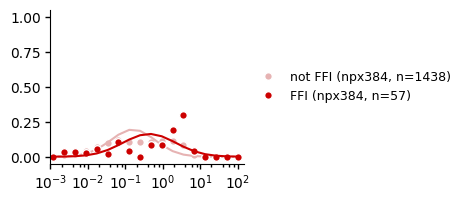

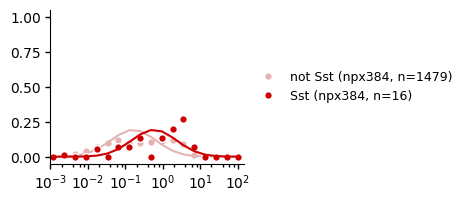

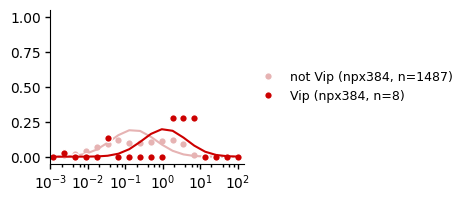

In [13]:
ax = plt.figure(figsize=(2.5, 2)).gca()

# parvalbumin (FFI)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(ffi_removed_rates_npx384),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not FFI (npx384, n={len(ffi_removed_rates_npx384)})",
    color=(0.9, 0.7, 0.7),
    markerfacecolor=(0.9, 0.7, 0.7),
    markeredgecolor="w",
    markersize=5.5,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(parv_rates_npx384),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"FFI (npx384, n={len(parv_rates_npx384)})",
    color=(0.8, 0, 0),
    markerfacecolor=(0.8, 0, 0),
    markeredgecolor="w",
    markersize=5.5,
    legend=False,
)
# axes[0].set_ylabel("probability (ratio)", fontsize=9);
# axes[0].set_title("npx.384 - hex01", fontsize=9);
# save figures

# axes[0].set_ylabel("probability (ratio)", fontsize=9)
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

plt.savefig("figures/2_realism/4_firing_rate/pdf/FFI_gt.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/FFI_gt.svg")
ax = plt.figure(figsize=(2.5, 2)).gca()

# somatostatin
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_removed_rates_npx384),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not Sst (npx384, n={len(sst_removed_rates_npx384)})",
    color=(0.9, 0.7, 0.7),
    markerfacecolor=(0.9, 0.7, 0.7),
    markeredgecolor="w",
    markersize=5.5,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_rates_npx384),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"Sst (npx384, n={len(sst_rates_npx384)})",
    color=(0.8, 0, 0),
    markerfacecolor=(0.8, 0, 0),
    markeredgecolor="w",
    markersize=5.5,
    legend=False,
)
# axes[1].set_ylabel("probability (ratio)", fontsize=9)
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
# save figures
plt.savefig("figures/2_realism/4_firing_rate/pdf/Sst_gt.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/Sst_gt.svg")
ax = plt.figure(figsize=(2.5, 2)).gca()

# vip
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_removed_rates_npx384),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"not Vip (npx384, n={len(vip_removed_rates_npx384)})",
    color=(0.9, 0.7, 0.7),
    markerfacecolor=(0.9, 0.7, 0.7),
    markeredgecolor="w",
    markersize=5.5,
    legend=False,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_rates_npx384),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label=f"Vip (npx384, n={len(vip_rates_npx384)})",
    color=(0.8, 0, 0),
    markerfacecolor=(0.8, 0, 0),
    markeredgecolor="w",
    markersize=5.5,
    legend=False,
)
# axes[2].set_ylabel("probability (ratio)", fontsize=9)
ax.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
# save figures
plt.savefig("figures/2_realism/4_firing_rate/pdf/Vip_gt.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/Vip_gt.svg")

### References

Extract data from log plot: 

(1) https://www.youtube.com/watch?v=x8Is7zW1uKs

(2) https://academia.stackexchange.com/questions/89624/is-it-ok-to-extract-datasets-from-somebodys-paper-and-work-with-it-in-your-own